In [1]:
!pip install --upgrade diffusers[torch] transformers git+https://github.com/huggingface/diffusers
!pip install peft
!pip install accelerate
!pip install bitsandbytes
!pip install jsonlines
!pip install safetensors

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-iyd1v1py
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-iyd1v1py
  Resolved https://github.com/huggingface/diffusers to commit f28a8c257afe8eeb16b4deb973c6b1829f6aea59
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 69.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.5/417.5 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 76.8 MB/s eta 0:00:00:00:01
  Created wheel for diffusers: filename=diffusers-0.31.0.dev0-py3-none-any.whl size=2739132 sha256=3d0f611b8539d312f1580e2e8b3cb4f1868cd43b217b

In [2]:
import pandas as pd
from PIL import Image
import io
import os
import shutil
import jsonlines
import json

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
df_dataset = pd.read_parquet('/kaggle/input/images-dnd/train-00000-of-00001-9b40395dcd3257f2 (2).parquet')

In [4]:
dir_name = 'images'
os.mkdir(dir_name)

In [5]:
filtered_df = df_dataset[df_dataset['text'].str.contains(r',\s*orc\b')]
filtered_df

,image,text
8,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"D&D Character, orc a woman with red hair and g..."
24,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"D&D Character, orc a woman sitting on the ground"
66,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"D&D Character, orc a werewolf with his arms cr..."
68,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"D&D Character, orc a man with a beard and a sword"
70,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"D&D Character, orc a creature in a cave"
...,...,...
2428,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"D&D Character, orc a woman with red hair and a..."
2442,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"D&D Character, orc a man holding a sword"
2447,{'bytes': b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHD...,"D&D Character, orc a woman with fire in her hands"
2472,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,"D&D Character, orc a man in armor"


In [6]:
df = []

for i in range(len(filtered_df)):
    dicta = filtered_df['image'].iloc[i]
    image = Image.open(io.BytesIO(dicta['bytes']))
    img_path = os.path.join(dir_name, f'{i}.jpg')
    image.save(img_path)
    df.append([f'{i}.jpg', filtered_df['text'].iloc[i]])

df = pd.DataFrame(df, columns=['file_name', 'text'])
data = df.to_dict('records')
jsonl = [json.dumps(obj) for obj in data]
with open('images/metadata.jsonl', "w") as f:
    f.write("\n".join(jsonl))
with open('images/metadata.jsonl', 'r') as file:
    content = file.read()
    print(content)
    

{"file_name": "0.jpg", "text": "D&D Character, orc a woman with red hair and green eyes"}
{"file_name": "1.jpg", "text": "D&D Character, orc a woman sitting on the ground"}
{"file_name": "2.jpg", "text": "D&D Character, orc a werewolf with his arms crossed"}
{"file_name": "3.jpg", "text": "D&D Character, orc a man with a beard and a sword"}
{"file_name": "4.jpg", "text": "D&D Character, orc a creature in a cave"}
{"file_name": "5.jpg", "text": "D&D Character, orc a man with a sword and a demon in the background"}
{"file_name": "6.jpg", "text": "D&D Character, orc a knight with a sword"}
{"file_name": "7.jpg", "text": "D&D Character, orc a man with a sword"}
{"file_name": "8.jpg", "text": "D&D Character, orc a character from the video game star wars"}
{"file_name": "9.jpg", "text": "D&D Character, orc a character from the video game diablo"}
{"file_name": "10.jpg", "text": "D&D Character, orc a man with a beard holding a bag"}
{"file_name": "11.jpg", "text": "D&D Character, orc a man in

In [7]:
command = (
           f'accelerate launch  --multi_gpu '
           f'/kaggle/usr/lib/prior/prior.py '
           f'--mixed_precision="fp16" '
           f'--train_data_dir="/kaggle/working/images" '
           f'--train_batch_size=3 '
           f'--num_train_epochs=200 '
           f'--learning_rate=1e-4 '
           f'--max_grad_norm=1 '
           f'--lr_scheduler="cosine_with_restarts" '
           f'--snr_gamma=5 '
           f'--use_8bit_adam '
           f'--scale_lr '
           f'--rank=16'
          )

!{command}

In [8]:
command = ( 
            f'accelerate launch  --multi_gpu '
           f'/kaggle/usr/lib/decoder/decoder.py '
           f'--mixed_precision="fp16" '
           f'--train_data_dir="/kaggle/working/images" '
           f'--train_batch_size=3 '
           f'--num_train_epochs=100 '
           f'--learning_rate=5e-5 '
           f'--lr_scheduler="cosine_with_restarts" '
           f'--snr_gamma=5 '
           f'--use_8bit_adam '
           f'--scale_lr '
           f'--rank=16 ' 
          )

!{command}

2024-09-11 00:42:37.935667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 00:42:37.935676: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 00:42:37.935770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 00:42:37.935801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 00:42:38.076542: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory

prior model:  can generate clip image embedding from text
decoder model: can generate images from clip image embedding

kandinskiy:
1. prior model ( в том числе image encoder)
2. decoder model (в том числе unet)

общий код для склейки: 


In [9]:
import sys
from diffusers import KandinskyV22Pipeline, KandinskyV22PriorPipeline
import torch
import PIL
from diffusers.utils import load_image
from safetensors.torch import load_file
from torchvision import transforms
from transformers import CLIPVisionModelWithProjection
from diffusers.models import UNet2DConditionModel
from peft import LoraConfig
import numpy as np

2024-09-11 01:39:40.201757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-11 01:39:40.202824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-11 01:39:40.313107: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [19]:
image_encoder = CLIPVisionModelWithProjection.from_pretrained('kandinsky-community/kandinsky-2-2-prior', subfolder='image_encoder').to(torch.float16).to('cuda')
unet = UNet2DConditionModel.from_pretrained('kandinsky-community/kandinsky-2-2-decoder', subfolder='unet').to(torch.float16).to('cuda')
prior = KandinskyV22PriorPipeline.from_pretrained('kandinsky-community/kandinsky-2-2-prior', image_encoder=image_encoder, torch_dtype=torch.float16)
prior = prior.to("cuda")
decoder = KandinskyV22Pipeline.from_pretrained('kandinsky-community/kandinsky-2-2-decoder', unet=unet, torch_dtype=torch.float16)
decoder = decoder.to("cuda")
negative_prior_prompt ='lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, fused fingers, too many fingers'



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (90 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['gross proportions, malformed limbs, fused fingers, too many fingers']


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

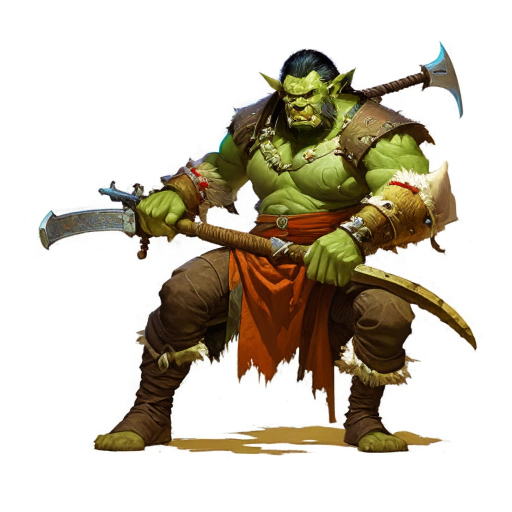

In [20]:
unet_lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0", "add_v_proj", "add_k_proj"],
    )

decoder.unet.add_adapter(unet_lora_config)
decoder.unet.load_state_dict(load_file('/kaggle/working/kandi_2_2-decoder-finetuned-lora/checkpoint-1550/model.safetensors'), strict=False)

prior_lora_config = LoraConfig(
        r=16,
        lora_alpha=16,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

prior.prior.add_adapter(prior_lora_config)
prior.prior.load_state_dict(load_file('/kaggle/input/0-75-prior-4/0-75_4rank.safetensors'), strict=False)
img_emb = prior(prompt='D&D Character, orc a man with a sword', num_inference_steps=300, num_images_per_prompt=5)
negative_emb = prior(prompt=negative_prior_prompt, num_inference_steps=300, num_images_per_prompt=5)
images = decoder(image_embeds=img_emb.image_embeds, negative_image_embeds=negative_emb.image_embeds, num_inference_steps=600, height=512, width=512)
images.images[0]

In [18]:
import gc
decoder = None
prior = None
unet = None
image_encoder = None
gc.collect()
torch.cuda.empty_cache()